# Train a deep, recurrent convolutional SNN on the SHD dataset

In this notebook, we demonstrate the training of a 3-layer convolutional SNN with recurrent connections in each hidden layer on the [SHD dataset](https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/).

We will introduce the use of the `layer` module to initialize feed-forward and recurrent connections at the same time, from the same target parameter $\sigma_U$.

In [1]:
# First, imports
import os
import sys
sys.path.append("../../stork/")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import stork.datasets
from stork.datasets import HDF5Dataset, DatasetView

from stork.loss_stacks import MeanOfSoftmaxCrossEntropy, SumOfSoftmaxCrossEntropy

from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import FluctuationDrivenCenteredNormalInitializer, DistInitializer
from stork.layers import ConvLayer, Layer

torch.set_num_threads(4)

using delay stork version - filter cascades


## Load Dataset

***To locally run this notebook on your system, download the SHD dataset from: [https://zenkelab.org/datasets/](https://zenkelab.org/datasets/).***
*We need 'shd_train.h5' and 'shd_test.h5'. Move the downloaded files into a folder `data/datasets/hdspikes` in this repo, or change the `datadir` variable below. 

In [2]:
datadir = "/tungstenfs/scratch/gzenke/datasets/hdspikes"

#### Specifying dataset parameters

In [3]:
nb_inputs = 700
duration = 0.7
time_step = dt = 2e-3
nb_time_steps = int(duration / time_step)
time_scale = 1
unit_scale = 1
validation_split = 0.9

sigma_u_augment = 10
dropout_p = 0.4


In [4]:

train_gen_kwargs = dict(
    nb_steps=nb_time_steps,
    time_scale=time_scale / time_step,
    unit_scale=unit_scale,
    nb_units=nb_inputs,
    preload=True,
    precompute_dense=False,
    unit_permutation=None,
    sigma_u_uniform=sigma_u_augment,
)

test_gen_kwargs = dict(
    nb_steps=nb_time_steps,
    time_scale=time_scale / time_step,
    unit_scale=unit_scale,
    nb_units=nb_inputs,
    preload=True,
    precompute_dense=False,
    unit_permutation=None,
    sigma_u_uniform=0,
)

#### Load and split dataset into train / validation / test

In [5]:
train_dataset = HDF5Dataset(os.path.join(datadir, "shd_train.h5"), **train_gen_kwargs)

# Split into train and validation set
mother_dataset = train_dataset
elements = np.arange(len(mother_dataset))
np.random.shuffle(elements)
split = int(validation_split * len(mother_dataset))
valid_dataset = DatasetView(mother_dataset, elements[split:])
train_dataset = DatasetView(mother_dataset, elements[:split])

test_dataset = HDF5Dataset(os.path.join(datadir, "shd_test.h5"), **test_gen_kwargs)

## Set up the model

In [6]:
# Model Parameters
# # # # # # # # # # #

beta = 20
nb_hidden_layers = 1
nb_classes = 20
nb_filters = [64, 32, 64]      # Number of features per layer

kernel_size = [21, 7, 7]  # Convolutional operation parameters
stride = [10, 3, 3]
padding = [0, 0, 0]

recurrent_kwargs = {"kernel_size": 5, "stride": 1, "padding": 2}

nb_hidden_units_dense = 1024
# Neuron Parameters
# # # # # # # # # # #

neuron_group = LIFGroup
tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = 200e-3
stochastic = True

# Training parameters
# # # # # # # # # # #

batch_size = 200
device = torch.device("cuda:1")
dtype = torch.float
lr = 5e-3
nb_epochs = 50

#### SuperSpike and loss function setup

In [7]:
act_fn = stork.activations.CustomSpike
if stochastic:
    act_fn.escape_noise_type = "sigmoid"
else:
    act_fn.escape_noise_type = "step"
act_fn.escape_noise_params = {"beta": beta}
act_fn.surrogate_type = "SuperSpike"
act_fn.surrogate_params = {"beta": beta}

loss_stack = stork.loss_stacks.SumOfSoftmaxCrossEntropy()

#### Optimizer setup

In [8]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
scheduler_kwargs = {
    "T_0": 10,
    "T_mult": 2,
    "eta_min": lr * 0.01,
    "last_epoch": -1,
}

opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=4)

#### Regularizer setup

In [9]:
# Define regularizer parameters (set regularizer strenght to 0, if you don't want to use them)
lowerBoundL2Strength = 0
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0
upperBoundL2Threshold = (
    7  # Regularizes spikecount: 7 spikes ~ 10 Hz in 700ms simulation time
)
weightL2Strength = 1e-4

# Define regularizer list
regs = []

regLB = stork.regularizers.LowerBoundL2(
    lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False
)
if lowerBoundL2Strength > 0:
    regs.append(regLB)

regUB = stork.regularizers.UpperBoundL2(
    upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1
)
if upperBoundL2Strength > 0:
    regs.append(regUB)

w_regs = []

regw = stork.regularizers.WeightL2Regularizer(strength=weightL2Strength)
if weightL2Strength > 0:
    w_regs.append(regw)

#### Initializer setup
We initialize in the fluctuation-driven regime with a target membrane potential standard deviation $\sigma_U=1.0$. Additionally, we set the proportion of membrane potential fluctuations driven by feed-forward inputs to $\alpha=0.9$.

In [10]:
sigma_u = 0.5
nu = 15.8

initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u = sigma_u,
    nu=nu,
    timestep = dt,
    alpha=0.9
    )

readout_initializer = DistInitializer(
    dist=torch.distributions.Normal(0, 1), scaling="1/sqrt(k)"
)

#### Assemble the model

In [11]:
model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)
# INPUT LAYER
# # # # # # # # # # # # # # #
input_shape = (1, nb_inputs)
input_group = model.add_group(InputGroup(input_shape))

# Set input group as upstream of first hidden layer
upstream_group = input_group

# HIDDEN LAYERS
# # # # # # # # # # # # # # #
neuron_kwargs = {
    "tau_mem": 20e-3,
    "tau_syn": 10e-3,
    "activation": act_fn,
    "dropout_p": dropout_p,
}

for layer_idx in range(nb_hidden_layers):

    # Generate Layer name and config
    layer_name = str("ConvLayer") + " " + str(layer_idx)

    # Make layer
    layer = ConvLayer(
        name=layer_name,
        model=model,
        input_group=upstream_group,
        kernel_size=kernel_size[layer_idx],
        stride=stride[layer_idx],
        padding=padding[layer_idx],
        nb_filters=nb_filters[layer_idx],
        recurrent=False,
        neuron_class=neuron_group,
        neuron_kwargs=neuron_kwargs,
        recurrent_connection_kwargs=recurrent_kwargs,
        regs=regs,
        w_regs=w_regs,
    )

    # Initialize Parameters
    initializer.initialize(layer)

    # Set output as input to next layer
    upstream_group = layer.output_group


# Add a dense recurrent layer
# # # # # # # # # # # # # # #
hidden_layer = Layer(
    "hidden",
    model,
    nb_hidden_units_dense,
    upstream_group,
    recurrent=True,
    regs=regs,
    w_regs=w_regs,
    neuron_kwargs=dict(
        tau_mem=tau_mem, tau_syn=tau_syn, activation=act_fn, dropout_p=dropout_p
    ),
)

upstream_group = hidden_layer.output_group

initializer.initialize(hidden_layer)


# READOUT LAYER
# # # # # # # # # # # # # # #
readout_group = model.add_group(
    ReadoutGroup(
        nb_classes,
        tau_mem=tau_readout,
        tau_syn=neuron_kwargs["tau_syn"],
        initial_state=-1e-3,
    )
)

readout_connection = model.add_connection(
    Connection(upstream_group, readout_group, flatten_input=True)
)

# Initialize readout connection
readout_initializer.initialize(readout_connection)

#### Add monitors for spikes and membrane potential

In [12]:
for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.SpikeCountMonitor(model.groups[1 + i]))

for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.StateMonitor(model.groups[1 + i], "out"))

#### Configure model for training

In [13]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    scheduler=scheduler,
    scheduler_kwargs=scheduler_kwargs,
    time_step=dt,
)

In [14]:
for c in model.connections:
    print(c.op.weight.shape)

torch.Size([64, 1, 21])
torch.Size([1024, 4352])
torch.Size([1024, 1024])
torch.Size([20, 1024])


In [15]:
model.groups[1].shape

(64, 68)

## Monitoring activity before training

In [16]:
results = {}

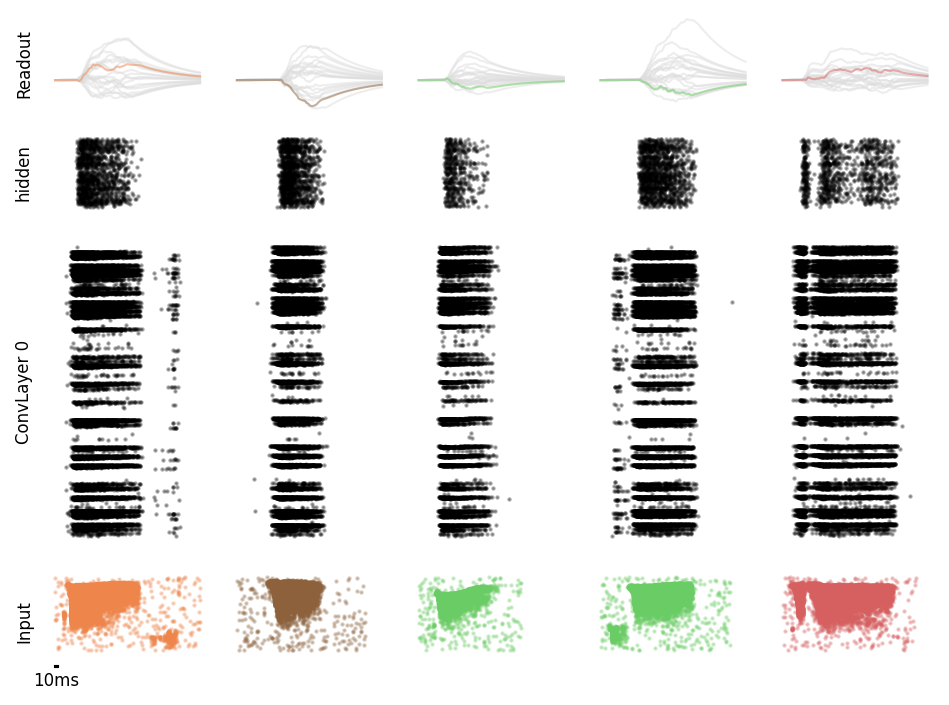

In [17]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model, data=test_dataset, nb_samples=5, point_alpha=0.3
)

## Training

takes around 85 minutes using a powerful GPU

In [32]:
history = model.fit_validate(
    train_dataset,
    valid_dataset,
    nb_epochs=nb_epochs,
    verbose=True)

00  loss=0.0525 reg_loss=4.75e-05 acc=0.983 -- val_loss=0.104 val_reg_loss=4.75e-05 val_acc=0.974 t_iter=27.31
01  loss=0.0473 reg_loss=4.75e-05 acc=0.983 -- val_loss=0.0955 val_reg_loss=4.75e-05 val_acc=0.97 t_iter=27.73
02  loss=0.0529 reg_loss=4.75e-05 acc=0.984 -- val_loss=0.0495 val_reg_loss=4.75e-05 val_acc=0.983 t_iter=27.91
03  loss=0.049 reg_loss=4.75e-05 acc=0.985 -- val_loss=0.0614 val_reg_loss=4.75e-05 val_acc=0.983 t_iter=28.05
04  loss=0.0436 reg_loss=4.75e-05 acc=0.985 -- val_loss=0.0457 val_reg_loss=4.75e-05 val_acc=0.982 t_iter=28.05
05  loss=0.0425 reg_loss=4.75e-05 acc=0.985 -- val_loss=0.0667 val_reg_loss=4.75e-05 val_acc=0.984 t_iter=28.10
06  loss=0.0458 reg_loss=4.76e-05 acc=0.984 -- val_loss=0.0514 val_reg_loss=4.76e-05 val_acc=0.985 t_iter=28.13
07  loss=0.0466 reg_loss=4.76e-05 acc=0.983 -- val_loss=0.0645 val_reg_loss=4.76e-05 val_acc=0.985 t_iter=28.10
08  loss=0.0472 reg_loss=4.76e-05 acc=0.985 -- val_loss=0.0585 val_reg_loss=4.76e-05 val_acc=0.985 t_iter=2

In [33]:
if "train_loss" in results:
    results["train_loss"] += history["loss"].tolist()
    results["train_acc"] += history["acc"].tolist()
    results["valid_loss"] += history["val_loss"].tolist()
    results["valid_acc"] += history["val_acc"].tolist()
else:
    results["train_loss"] = history["loss"].tolist()
    results["train_acc"] = history["acc"].tolist()
    results["valid_loss"] = history["val_loss"].tolist()
    results["valid_acc"] = history["val_acc"].tolist()

## Test

In [34]:
scores = model.evaluate(test_dataset).tolist()
results["test_loss"], _, results["test_acc"] = scores

#### Visualize performance

Test loss:  0.44912947217623395
Test acc.:  0.90921875


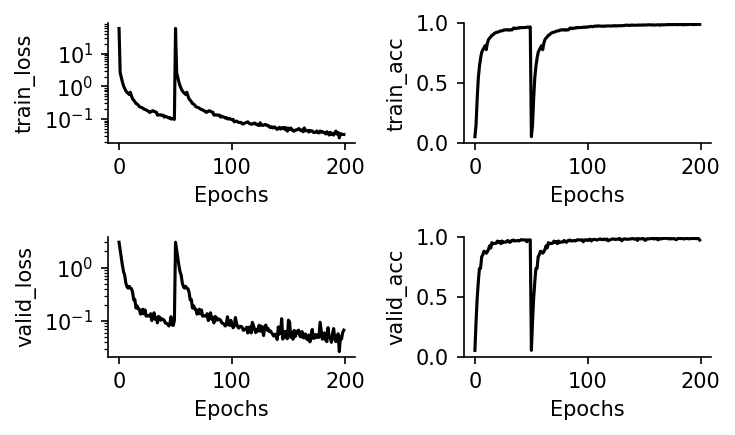

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(5, 3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc", "valid_loss", "valid_acc"]):

    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i - 2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

    if "loss" in n:
        a.set_yscale("log")

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"])
print("Test acc.: ", results["test_acc"])

#### Snapshot after training

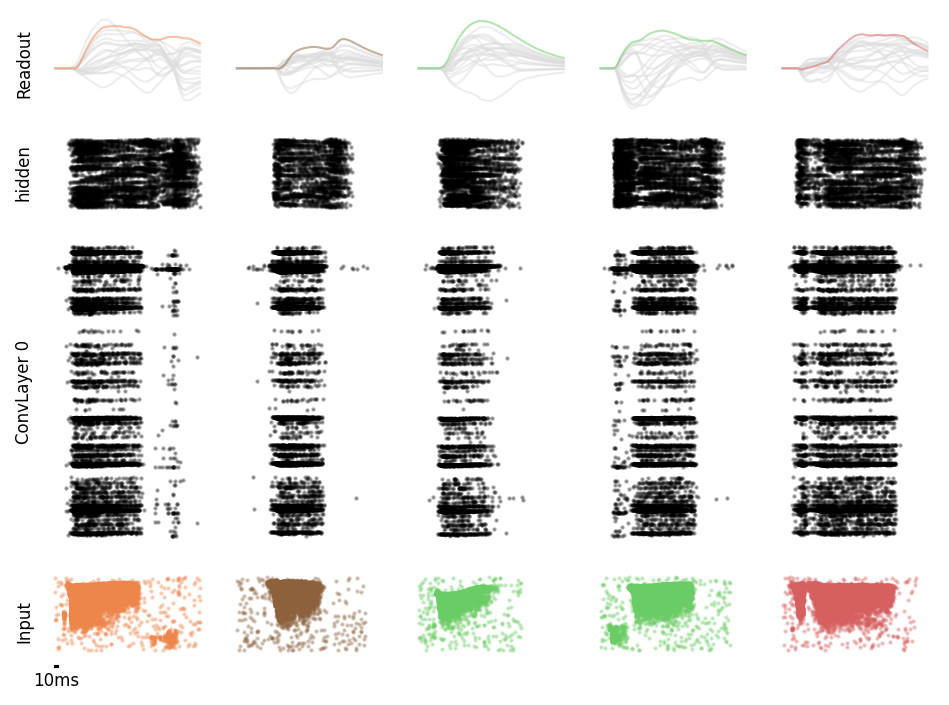

In [36]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model, data=test_dataset, nb_samples=5, point_alpha=0.3
)